In [ ]:
# importando librerías
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import torchsummary as ts
from torchvision.utils import make_grid
import numpy as np
import plotly.express as px
import time
import copy
from PIL import Image

In [ ]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = ('cuda' if torch.cuda.is_available() else 'cpu')

## ***   Importacion de la Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ruta_directorio='/content/drive/MyDrive/Diplomado_IA_PUCP/Modulo_2/Desarrollo en Aplicaciones con Visión Artificial/Trabajo Final Grupo/Visión Artificial/Data'

In [ ]:
# Definiendo el dataset
dataset = datasets.ImageFolder(ruta_directorio,
                              transform=transforms.Compose([
                                  #transforms.RandomResizedCrop(224),
                                  transforms.Resize(255),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])
                                  ]))

class_names = dataset.classes
print(class_names)

['Covid', 'Neumonia', 'Normal']


In [ ]:
print(dataset[0][0].shape) # dimension del tensor

torch.Size([3, 224, 224])


In [ ]:
print(dataset[0][0].shape)

torch.Size([3, 224, 224])


In [ ]:
import collections
c = collections.Counter(dataset.targets)
print(c)

Counter({1: 4265, 0: 4077, 2: 1585})


In [ ]:
dataset[9926][0]

tensor([[[-0.4226, -0.5253, -0.6281,  ..., -1.1932, -1.1932, -1.2103],
         [-0.4739, -0.4911, -0.5424,  ..., -1.1932, -1.1760, -1.2103],
         [-0.5938, -0.5082, -0.4911,  ..., -1.1932, -1.1932, -1.2103],
         ...,
         [ 0.8447,  0.8961,  0.8961,  ...,  0.2453,  0.2796, -0.2856],
         [ 0.8104,  0.8961,  0.9132,  ...,  0.2624,  0.1768, -0.3198],
         [ 0.7933,  0.8789,  0.9303,  ...,  0.2111,  0.1597, -0.3541]],

        [[-0.3025, -0.4076, -0.5126,  ..., -1.0903, -1.0903, -1.1078],
         [-0.3550, -0.3725, -0.4251,  ..., -1.0903, -1.0728, -1.1078],
         [-0.4776, -0.3901, -0.3725,  ..., -1.0903, -1.0903, -1.1078],
         ...,
         [ 0.9930,  1.0455,  1.0455,  ...,  0.3803,  0.4153, -0.1625],
         [ 0.9580,  1.0455,  1.0630,  ...,  0.3978,  0.3102, -0.1975],
         [ 0.9405,  1.0280,  1.0805,  ...,  0.3452,  0.2927, -0.2325]],

        [[-0.0790, -0.1835, -0.2881,  ..., -0.8633, -0.8633, -0.8807],
         [-0.1312, -0.1487, -0.2010,  ..., -0

In [ ]:
dataset[9926][1]

2

In [ ]:
dataset.targets[9926]

2

In [ ]:
len(dataset)

9927

In [ ]:
models.*?

## *** Particion de la data**

In [ ]:
# Particionamos en subconjuntos de entrenamiento y prueba
n_test = int(len(dataset) * 0.3)
n_train = len(dataset) - n_test

# Semilla para que los valores sean reproducibles
generator = torch.Generator()
generator.manual_seed(0)

train_dataset, test_dataset = random_split(dataset, [n_train, n_test],generator=generator)

print(f'n_train={len(train_dataset)}')
print(f'n_test={len(test_dataset)}')

n_train=6949
n_test=2978


In [ ]:
# Particionamos los subconjuntos en minibatches
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)


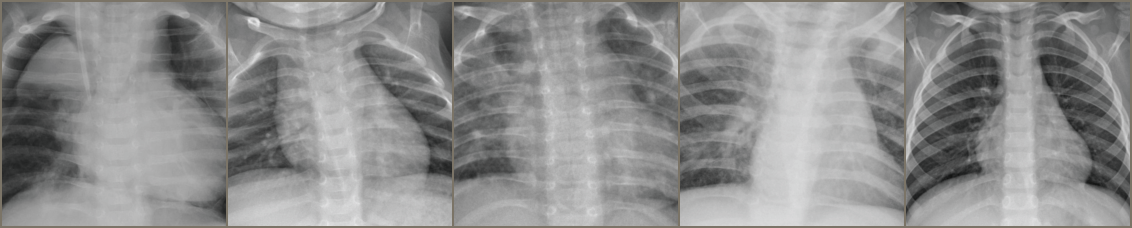

In [ ]:
# Mostramos algunos ejemplos
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  fig = px.imshow(inp, title=title)
  fig.update_layout(title_x=0.1)
  fig.show()

inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title='                       '.join(str(class_names[x]) for x in classes))

In [ ]:
# Función de entrenamiento y validación
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  rs = '------------------------------------------------------------------'
  print('Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best')
  print(rs)
  
  for epoch in range(num_epochs):
    
    # Entrenamiento
    model.train()
    
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
        
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
    
    result = {}
    result['train_loss'] = running_loss /len(train_dataset)
    result['train_acc'] = running_corrects.double() / len(train_dataset)

    scheduler.step()
    
    # Validación 
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
        
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
          
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
     
    result['val_loss'] = running_loss /len(test_dataset)
    result['val_acc'] = running_corrects.double() / len(test_dataset)
    epoch_acc = result['val_acc']
      
    st = '          '
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(model.state_dict())
      st = '   ***    '
        
    print("%5d %11.4f %11.4f %11.4f %11.4f %s" % (epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc'], st))

  print(rs)
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val accuracy: {best_acc:.4f}')

  model.load_state_dict(best_model_wts)
  return model

## *** Entrenamiento de Modelos**

### **0. Reentrenando Modelo AlexNet**

In [ ]:
# Definiendo el modelo
ft_alexnet = models.alexnet(pretrained=True)
print(ft_alexnet)

ts.summary(ft_alexnet, (3,224,224))

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### *Finetuning en todas las capas*

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

# Modificamos la última capa y entrenamos
ft_alexnet = models.alexnet(pretrained=True)

ft_alexnet.classifier[4] = nn.Linear(4096,1000)
ft_alexnet.classifier[6] = nn.Linear(in_features=1000, out_features=3)
ft_alexnet = ft_alexnet.to(device)

ft_criterion = nn.CrossEntropyLoss()
ft_optimizer = torch.optim.SGD(ft_alexnet.parameters(), lr=0.001, momentum=0.9)
ft_scheduler = torch.optim.lr_scheduler.StepLR(ft_optimizer, step_size=7, gamma=0.1)

ft_alexnet = train_model(ft_alexnet, ft_criterion, ft_optimizer, ft_scheduler, num_epochs=2)

Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best
------------------------------------------------------------------
    0      0.1707      0.9373      0.0983      0.9688    ***    
    1      0.0930      0.9655      0.0840      0.9711    ***    
------------------------------------------------------------------
Training complete in 50m 46s
Best val accuracy: 0.9711


In [ ]:
#Training Accuracy General
correct_train = 0
total_train = 0
with torch.no_grad():
    for data in train_loader:
        images = data[0]#.to(device)
        labels = data[1]#.to(device)
        outputs = ft_alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

#Testing Accuracy General
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in test_loader:
        images = data[0]#.to(device)
        labels = data[1]#.to(device)
        outputs = ft_alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

print('===== Train =====')
print('Accuracy : {:.2%}'.format(correct_train / total_train))
print('=================\n')

print('=====  Test =====')
print('Accuracy : {:.2%}'.format(correct_test / total_test))
print('=================')

===== Train =====
Accuracy : 98.04%

=====  Test =====
Accuracy : 97.11%


In [ ]:
#Training Accuracy por clase
class_correct_train = list(0. for i in range(3))
class_total_train = list(0. for i in range(3))
with torch.no_grad():
    for data in train_loader:
        images = data[0]#.to(device)
        labels = data[1]#.to(device)
        outputs = ft_alexnet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct_train[label] += c[i].item()
            class_total_train[label] += 1

#Testing Accuracy por clase
class_correct_test = list(0. for i in range(3))
class_total_test = list(0. for i in range(3))
with torch.no_grad():
    for data in test_loader:
        images = data[0]#.to(device)
        labels = data[1]#.to(device)
        outputs = ft_alexnet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct_test[label] += c[i].item()
            class_total_test[label] += 1

print('===== Train =====')
for i in range(3):
    print('Accuracy of {} : {:.2%}'.format(class_names[i], class_correct_train[i] / class_total_train[i]))
print('=================\n')

print('===== Test =====')
for i in range(3):
    print('Accuracy of {} : {:.2%}'.format(class_names[i], class_correct_test[i] / class_total_test[i]))
print('=================\n')

===== Train =====
Accuracy of Covid : 99.94%
Accuracy of Neumonia : 97.65%
Accuracy of Normal : 96.04%

===== Test =====
Accuracy of Covid : 99.14%
Accuracy of Neumonia : 97.13%
Accuracy of Normal : 91.59%



##### Guardado y carga del Modelo

In [ ]:
torch.save(ft_alexnet, '/content/drive/MyDrive/Diplomado_IA_PUCP/Modulo_2/Desarrollo en Aplicaciones con Visión Artificial/Trabajo Final Grupo/Visión Artificial/ft_alexnet.pt')
ft_alexnet = torch.load('/content/drive/MyDrive/Diplomado_IA_PUCP/Modulo_2/Desarrollo en Aplicaciones con Visión Artificial/Trabajo Final Grupo/Visión Artificial/ft_alexnet.pt', map_location=lambda storage, loc: storage)


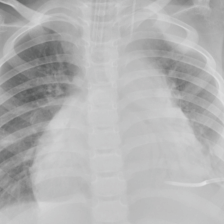


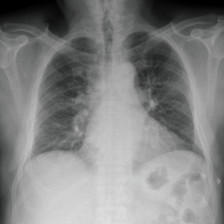


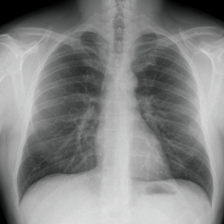


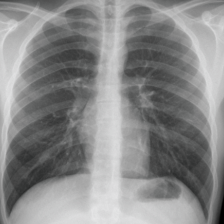


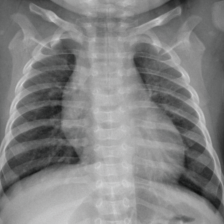


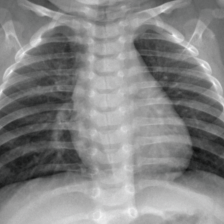


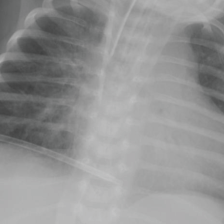


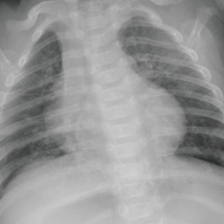

In [ ]:
# Mostramos las predicciones
def visualize_model(model, num_images = 8):
  was_training = model.training
  model.eval()
  images_so_far = 0
  
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      outputs = model(inputs)
      #conf, preds = torch.max(outputs, 1)
      outputs = F.softmax(outputs, dim=-1)
      conf, preds = outputs.max(1)

      
      
      for j in range(inputs.size()[0]):
        images_so_far += 1
        imshow(inputs.cpu().data[j], f'Clase Predicha: {class_names[preds[j]]}  -  Probabilidad :{conf[j]*100}%  - Clase Real : {class_names[labels[j]]} ' )
        
        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode = was_training)

visualize_model(ft_alexnet)

#### *Finetuning el la última capa lineal*

In [ ]:
# Freeze
fr_alexnet = models.alexnet(pretrained=True)

for param in fr_alexnet.parameters():
  param.requires_grad = False

device = ('cuda' if torch.cuda.is_available() else 'cpu')

fr_alexnet.classifier[4] = nn.Linear(4096,1000)
fr_alexnet.classifier[6] = nn.Linear(in_features=1000, out_features=3)
fr_alexnet = fr_alexnet.to(device)

fr_criterion = nn.CrossEntropyLoss()
fr_optimizer = torch.optim.SGD(fr_alexnet.parameters(), lr=0.001, momentum=0.9)
fr_scheduler = torch.optim.lr_scheduler.StepLR(fr_optimizer, step_size=7, gamma=0.1)

fr_alexnet = train_model(fr_alexnet, fr_criterion, fr_optimizer, fr_scheduler, num_epochs=2)

Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best
------------------------------------------------------------------
    0      0.2038      0.9288      0.1055      0.9617    ***    
    1      0.1467      0.9468      0.1196      0.9594           
------------------------------------------------------------------
Training complete in 93m 3s
Best val accuracy: 0.9617


In [ ]:
#Training Accuracy General
correct_train = 0
total_train = 0
with torch.no_grad():
    for data in train_loader:
        images = data[0]#.to(device)
        labels = data[1]#.to(device)
        outputs = fr_alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

#Testing Accuracy General
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in test_loader:
        images = data[0]#.to(device)
        labels = data[1]#.to(device)
        outputs = fr_alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

print('===== Train =====')
print('Accuracy : {:.2%}'.format(correct_train / total_train))
print('=================\n')

print('=====  Test =====')
print('Accuracy : {:.2%}'.format(correct_test / total_test))
print('=================')

===== Train =====
Accuracy : 96.69%

=====  Test =====
Accuracy : 96.17%


In [ ]:
#Training Accuracy por clase
class_correct_train = list(0. for i in range(3))
class_total_train = list(0. for i in range(3))
with torch.no_grad():
    for data in train_loader:
        images = data[0]#.to(device)
        labels = data[1]#.to(device)
        outputs = fr_alexnet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct_train[label] += c[i].item()
            class_total_train[label] += 1

#Testing Accuracy por clase
class_correct_test = list(0. for i in range(3))
class_total_test = list(0. for i in range(3))
with torch.no_grad():
    for data in test_loader:
        images = data[0]#.to(device)
        labels = data[1]#.to(device)
        outputs = fr_alexnet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct_test[label] += c[i].item()
            class_total_test[label] += 1

print('===== Train =====')
for i in range(3):
    print('Accuracy of {} : {:.2%}'.format(class_names[i], class_correct_train[i] / class_total_train[i]))
print('=================\n')

print('===== Test =====')
for i in range(3):
    print('Accuracy of {} : {:.2%}'.format(class_names[i], class_correct_test[i] / class_total_test[i]))
print('=================\n')

===== Train =====
Accuracy of Covid : 99.71%
Accuracy of Neumonia : 95.20%
Accuracy of Normal : 91.07%

===== Test =====
Accuracy of Covid : 99.01%
Accuracy of Neumonia : 95.67%
Accuracy of Normal : 90.04%



##### Guardado y carga del Modelo

In [ ]:
#torch.save(fr_alexnet, '/content/drive/MyDrive/Diplomado_IA_PUCP/Modulo_2/Desarrollo en Aplicaciones con Visión Artificial/Trabajo Final Grupo/Visión Artificial/fr_alexnet.pt')
fr_alexnet = torch.load('/content/drive/MyDrive/Diplomado_IA_PUCP/Modulo_2/Desarrollo en Aplicaciones con Visión Artificial/Trabajo Final Grupo/Visión Artificial/fr_alexnet.pt', map_location=lambda storage, loc: storage)

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

inputs, labels = next(iter(train_loader))
inputs = inputs.to(device)
labels = labels.to(device)

outputs = fr_alexnet(inputs)
_, preds = torch.max(outputs, 1)
preds

tensor([0, 1, 1, 0, 0])


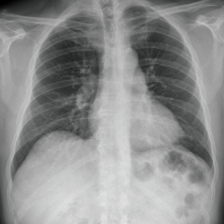


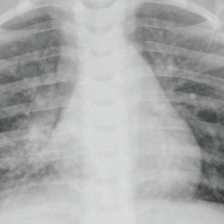


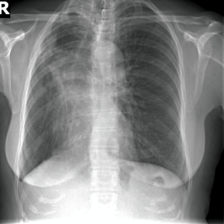


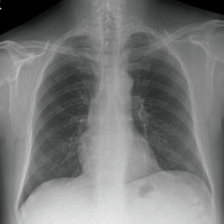


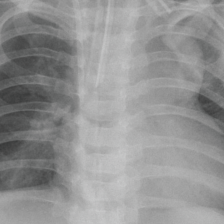


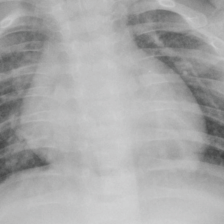


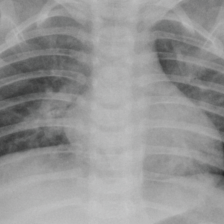


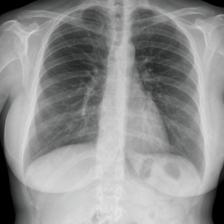

In [ ]:
# Mostramos las predicciones
def visualize_model(model, num_images = 8):
  was_training = model.training
  model.eval()
  images_so_far = 0
  
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      outputs = model(inputs)
      #conf, preds = torch.max(outputs, 1)
      outputs = F.softmax(outputs, dim=-1)
      conf, preds = outputs.max(1)

      
      
      for j in range(inputs.size()[0]):
        images_so_far += 1
        imshow(inputs.cpu().data[j], f'Clase Predicha: {class_names[preds[j]]}  -  Probabilidad :{conf[j]*100}%  - Clase Real : {class_names[labels[j]]} ' )
        
        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode = was_training)

visualize_model(fr_alexnet)

### **1. Reentrenando Modelo resnet 18**

In [ ]:
# Definimos el modelo
ft_model18 = models.resnet18(pretrained=True)
print(ft_model18)

ts.summary(ft_model18, (3,224,224))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### *Finetuning en todas las capas*

In [ ]:
# Modificamos la última capa y entrenamos
device = ('cuda' if torch.cuda.is_available() else 'cpu')

ft_model18.fc = nn.Linear(in_features=512, out_features=3)
ft_model18 = ft_model18.to(device)

ft_criterion = nn.CrossEntropyLoss()
ft_optimizer = torch.optim.SGD(ft_model18.parameters(), lr=0.001, momentum=0.9)
ft_scheduler = torch.optim.lr_scheduler.StepLR(ft_optimizer, step_size=7, gamma=0.1)

ft_model18 = train_model(ft_model18, ft_criterion, ft_optimizer, ft_scheduler, num_epochs=2)


Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best
------------------------------------------------------------------
    0      0.2513      0.9106      0.1341      0.9516    ***    
    1      0.1397      0.9554      0.0681      0.9799    ***    
------------------------------------------------------------------
Training complete in 83m 17s
Best val accuracy: 0.9799


In [ ]:
#Training Accuracy General
correct_train = 0
total_train = 0
with torch.no_grad():
    for data in train_loader:
        images = data[0]#.to(device)
        labels = data[1]#.to(device)
        outputs = ft_model18(images)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

#Testing Accuracy General
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in test_loader:
        images = data[0]#.to(device)
        labels = data[1]#.to(device)
        outputs = ft_model18(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

print('===== Train =====')
print('Accuracy : {:.2%}'.format(correct_train / total_train))
print('=================\n')

print('=====  Test =====')
print('Accuracy : {:.2%}'.format(correct_test / total_test))
print('=================')

===== Train =====
Accuracy : 98.65%

=====  Test =====
Accuracy : 97.99%


In [ ]:
#Training Accuracy por clase
class_correct_train = list(0. for i in range(3))
class_total_train = list(0. for i in range(3))
with torch.no_grad():
    for data in train_loader:
        images = data[0]#.to(device)
        labels = data[1]#.to(device)
        outputs = ft_model18(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct_train[label] += c[i].item()
            class_total_train[label] += 1

#Testing Accuracy por clase
class_correct_test = list(0. for i in range(3))
class_total_test = list(0. for i in range(3))
with torch.no_grad():
    for data in test_loader:
        images = data[0]#.to(device)
        labels = data[1]#.to(device)
        outputs = ft_model18(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct_test[label] += c[i].item()
            class_total_test[label] += 1

print('===== Train =====')
for i in range(3):
    print('Accuracy of {} : {:.2%}'.format(class_names[i],class_correct_train[i] / class_total_train[i]))
print('=================\n')

print('===== Test =====')
for i in range(3):
    print('Accuracy of {} : {:.2%}'.format(class_names[i],class_correct_test[i] / class_total_test[i]))
print('=================\n')

===== Train =====
Accuracy of Covid : 99.83%
Accuracy of Neumonia : 99.94%
Accuracy of Normal : 92.30%

===== Test =====
Accuracy of Covid : 99.17%
Accuracy of Neumonia : 99.48%
Accuracy of Normal : 92.31%



In [ ]:
inputs, labels = next(iter(train_loader))
inputs = inputs.to(device)
labels = labels.to(device)

outputs = ft_model18(inputs)
_, preds = torch.max(outputs, 1)
preds

tensor([0, 0, 0, 1, 0])


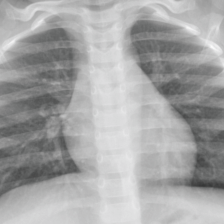


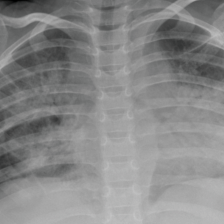


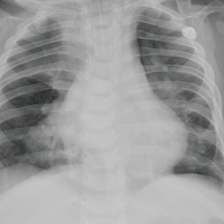


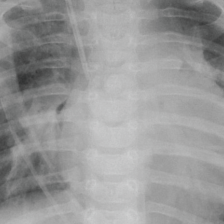


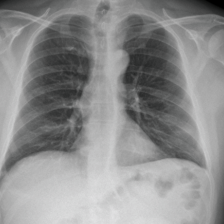


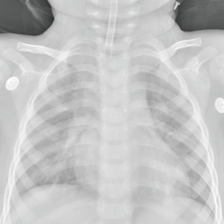


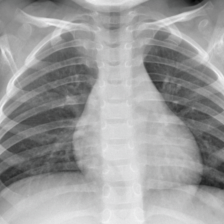


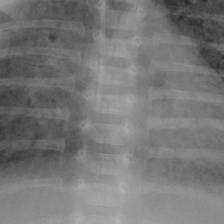

In [ ]:
# Mostramos las predicciones
def visualize_model(model, num_images = 8):
  was_training = model.training
  model.eval()
  images_so_far = 0
  
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      outputs = model(inputs)
      #conf, preds = torch.max(outputs, 1)
      outputs = F.softmax(outputs, dim=-1)
      conf, preds = outputs.max(1)

      
      
      for j in range(inputs.size()[0]):
        images_so_far += 1
        imshow(inputs.cpu().data[j], f'Clase Predicha: {class_names[preds[j]]}  -  Probabilidad :{conf[j]*100}%  - Clase Real : {class_names[labels[j]]} ' )
        
        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode = was_training)

visualize_model(ft_model18)

##### Guardado y carga del Modelo

In [ ]:
torch.save(ft_model18, '/content/drive/MyDrive/Diplomado_IA_PUCP/Modulo_2/Desarrollo en Aplicaciones con Visión Artificial/Trabajo Final Grupo/Visión Artificial/ft_model18.pt')
ft_model18 = torch.load('/content/drive/MyDrive/Diplomado_IA_PUCP/Modulo_2/Desarrollo en Aplicaciones con Visión Artificial/Trabajo Final Grupo/Visión Artificial/ft_model18.pt', map_location=lambda storage, loc: storage)

#### *Finetuning el la última capa lineal*

In [ ]:
# Freeze
fr_model18 = models.resnet18(pretrained=True)

for param in fr_model18.parameters():
  param.requires_grad = False

device = ('cuda' if torch.cuda.is_available() else 'cpu')

fr_model18.fc = nn.Linear(512, 3) # requires_grad = True
fr_model18 = fr_model18.to(device)

fr_criterion = nn.CrossEntropyLoss()
fr_optimizer = torch.optim.SGD(fr_model18.parameters(), lr=0.001, momentum=0.9)
fr_scheduler = torch.optim.lr_scheduler.StepLR(fr_optimizer, step_size=7, gamma=0.1)

fr_model2 = train_model(fr_model18, fr_criterion, fr_optimizer, fr_scheduler, num_epochs=2)

Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best
------------------------------------------------------------------
    0      0.3867      0.8518      0.1554      0.9500    ***    
    1      0.2974      0.8903      0.1303      0.9577    ***    
------------------------------------------------------------------
Training complete in 39m 26s
Best val accuracy: 0.9577


In [ ]:
#Training Accuracy General
correct_train = 0
total_train = 0
with torch.no_grad():
    for data in train_loader:
        images = data[0]#.to(device)
        labels = data[1]#.to(device)
        outputs = fr_model18(images)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

#Testing Accuracy General
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in test_loader:
        images = data[0]#.to(device)
        labels = data[1]#.to(device)
        outputs = fr_model18(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

print('===== Train =====')
print('Accuracy : {:.2%}'.format(correct_train / total_train))
print('=================\n')

print('=====  Test =====')
print('Accuracy : {:.2%}'.format(correct_test / total_test))
print('=================')

===== Train =====
Accuracy : 96.23%

=====  Test =====
Accuracy : 95.77%


In [ ]:
#Training Accuracy por clase
class_correct_train = list(0. for i in range(3))
class_total_train = list(0. for i in range(3))
with torch.no_grad():
    for data in train_loader:
        images = data[0]#.to(device)
        labels = data[1]#.to(device)
        outputs = fr_model18(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct_train[label] += c[i].item()
            class_total_train[label] += 1

#Testing Accuracy por clase
class_correct_test = list(0. for i in range(3))
class_total_test = list(0. for i in range(3))
with torch.no_grad():
    for data in test_loader:
        images = data[0]#.to(device)
        labels = data[1]#.to(device)
        outputs = fr_model18(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct_test[label] += c[i].item()
            class_total_test[label] += 1

print('===== Train =====')
for i in range(3):
    print('Accuracy of {} : {:.2%}'.format(class_names[i],class_correct_train[i] / class_total_train[i]))
print('=================\n')

print('===== Test =====')
for i in range(3):
    print('Accuracy of {} : {:.2%}'.format(class_names[i],class_correct_test[i] / class_total_test[i]))
print('=================\n')

===== Train =====
Accuracy of Covid : 99.94%
Accuracy of Neumonia : 96.05%
Accuracy of Normal : 84.57%

===== Test =====
Accuracy of Covid : 99.86%
Accuracy of Neumonia : 95.99%
Accuracy of Normal : 86.32%




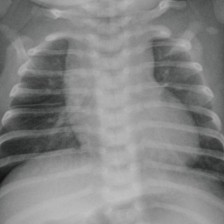


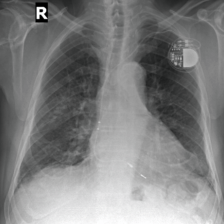


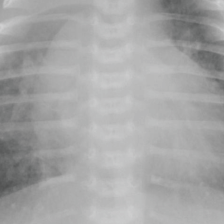


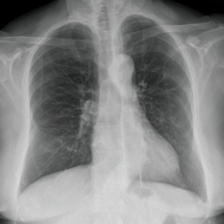


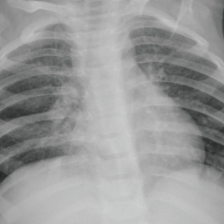


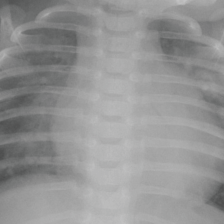


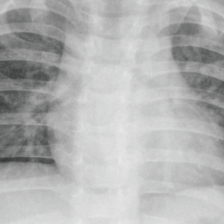


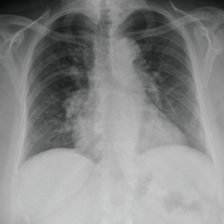

In [ ]:
# Mostramos las predicciones
def visualize_model(model, num_images = 8):
  was_training = model.training
  model.eval()
  images_so_far = 0
  
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      outputs = model(inputs)
      #conf, preds = torch.max(outputs, 1)
      outputs = F.softmax(outputs, dim=-1)
      conf, preds = outputs.max(1)

      
      
      for j in range(inputs.size()[0]):
        images_so_far += 1
        imshow(inputs.cpu().data[j], f'Clase Predicha: {class_names[preds[j]]}  -  Probabilidad :{conf[j]*100}%  - Clase Real : {class_names[labels[j]]} ' )
        
        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode = was_training)

visualize_model(fr_model18)

##### Guardado y carga del Modelo

In [ ]:
torch.save(fr_model18, '/content/drive/MyDrive/Diplomado_IA_PUCP/Modulo_2/Desarrollo en Aplicaciones con Visión Artificial/Trabajo Final Grupo/Visión Artificial/fr_model18.pt')
fr_model18 = torch.load('/content/drive/MyDrive/Diplomado_IA_PUCP/Modulo_2/Desarrollo en Aplicaciones con Visión Artificial/Trabajo Final Grupo/Visión Artificial/fr_model18.pt', map_location=lambda storage, loc: storage)

## *** Prediccion para nuevas imagenes**

In [ ]:
def transformar_imagen(name):
  '''
  Pre procesamiento de la imagen
  '''
  transf = transforms.Compose([transforms.Resize(255),
                      transforms.CenterCrop(224),
                      transforms.ToTensor(), # entre 0 y 1
                      transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]) # medias y desviacion estandar (Welford's method)
  image = Image.open(name)
  # Tamaño (3,224,224) => (1, 3, 224, 224)
  return transf(image).unsqueeze(0) # tensor singleton

def prediccion(network, name):
  '''
  se agrupan las funciones para predecir la clase de la imagen
  '''
  tensor = transformar_imagen(name)
  network.eval()
  pred = network(tensor)
  output = F.softmax(pred, dim=-1)
  _,val = output.max(1)
  return class_names[val]

def prediccion2(network, name):
  '''
  Predicción con grado de confidencia
  '''
  tensor = transformar_imagen(name)
  network.eval()
  pred = network(tensor)
  output = F.softmax(pred, dim=-1)
  conf,val = output.max(1)
  #return {'Clase_Predicha':class_names[val] , 'Probabilidad':conf[0]*100}
  return print('Clase_Predicha :',class_names[val] , '  -  Probabilidad :',float(conf[0]*100) ,'%')

In [ ]:
#Ruta de la imagen
nueva_imagen='/content/drive/MyDrive/Diplomado_IA_PUCP/Modulo_2/Desarrollo en Aplicaciones con Visión Artificial/Trabajo Final Grupo/Visión Artificial/WhatsApp Image 2023-03-23 at 9.24.10 PM.jpeg'

Clase_Predicha : Covid   -  Probabilidad : 99.95280456542969 %


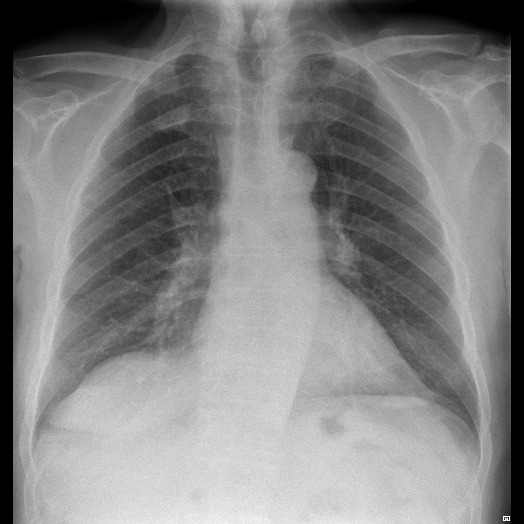

In [ ]:
prediccion2(ft_model18, nueva_imagen)
Image.open(nueva_imagen)